In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/robertalarge/config.json
/kaggle/input/robertalarge/merges.txt
/kaggle/input/robertalarge/vocab.json
/kaggle/input/robertalarge/pytorch_model.bin
/kaggle/input/robertalarge/modelcard.json
/kaggle/input/commonlitreadabilityprize/sample_submission.csv
/kaggle/input/commonlitreadabilityprize/train.csv
/kaggle/input/commonlitreadabilityprize/test.csv
/kaggle/input/roberta-base/config.json
/kaggle/input/roberta-base/merges.txt
/kaggle/input/roberta-base/vocab.json
/kaggle/input/roberta-base/pytorch_model.bin


In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt 
import torch 
import time
from torch import nn
from torch import optim
from torch.utils.data import DataLoader,Dataset,TensorDataset
from transformers import RobertaModel,RobertaTokenizer,AutoTokenizer,AdamW,get_linear_schedule_with_warmup,get_constant_schedule
from collections import defaultdict
import os

# Read Data

In [3]:
train=pd.read_csv('/kaggle/input/commonlitreadabilityprize/train.csv')
test=pd.read_csv('/kaggle/input/commonlitreadabilityprize/test.csv')

In [4]:
train['length']=train.excerpt.astype(str).apply(lambda x: len(x.split()))
test['length']=test.excerpt.astype(str).apply(lambda x: len(x.split()))

In [5]:
train['number_sentence']=train.excerpt.astype(str).apply(lambda x: len(x.split('.')))
test['number_sentence']=test.excerpt.astype(str).apply(lambda x:len(x.split('.')))

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='number_sentence', ylabel='count'>

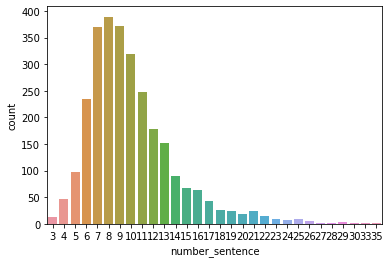

In [6]:
sns.countplot(train.number_sentence)

In [7]:
train.drop(['url_legal','license','standard_error'],axis=1,inplace=True)
test.drop(['url_legal','license'],axis=1,inplace=True)

In [8]:
train.describe()

,target,length,number_sentence
count,2834.000000,2834.000000,2834.000000
mean,-0.959319,172.982004,10.034933
std,1.033579,16.974390,3.977946
min,-3.676268,135.000000,3.000000
25%,-1.690320,159.000000,7.000000
50%,-0.912190,175.000000,9.000000
75%,-0.202540,188.000000,12.000000
max,1.711390,205.000000,35.000000


# DataLoader

In [9]:
def convert_features(excerpt,tokenizer,max_length):
    excerpt=excerpt.replace('\n','')
    token=tokenizer.encode_plus(
        excerpt,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return token['input_ids'].squeeze(dim=0),token['attention_mask'].squeeze(dim=0)

class ColeridgeInitiative(Dataset):
    def __init__(self,data,tokenizer,max_length=256,is_test=False):
        self.tokenizer=tokenizer
        self.max_length=max_length
        self.data=data
        self.is_test=is_test
        self.excerpts=self.data.excerpt.values.tolist()
        if is_test is False:
            self.targets=self.data.target.values.tolist()
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        if self.is_test is False:
            excerpt,target=self.excerpts[idx],self.targets[idx]
            input_ids,attention_mask=convert_features(excerpt,tokenizer,self.max_length)
            return {
                "input_ids":input_ids,
                "attention_mask":attention_mask,
                "target":torch.tensor(target,dtype=torch.float)
            }
        else:
            excerpt=self.excerpts[idx]
            input_ids,attention_mask=convert_features(excerpt,tokenizer,self.max_length)
            return {
                "input_ids":input_ids,
                "attention_mask":attention_mask
            }
    

In [10]:
tokenizer=RobertaTokenizer.from_pretrained('/kaggle/input/roberta-base')

In [11]:
train_dataset=ColeridgeInitiative(train,tokenizer)
test_dataset=ColeridgeInitiative(test,tokenizer,is_test=True)

In [12]:
batch_size=32
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True,num_workers=2)
test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,pin_memory=True,num_workers=2)

In [13]:
outputs=next(iter(train_loader))
print(outputs['input_ids'].size())
print(outputs['target'])
print(outputs['attention_mask'].size())

torch.Size([32, 256])
tensor([-2.1864, -0.5692, -2.3906, -2.0637, -2.2551, -1.3808, -2.1693, -1.1549,
        -0.4177, -1.6580,  0.0247, -0.3064, -1.8423, -0.9111, -2.3837, -1.5942,
        -0.9295, -1.7136,  0.0987, -3.2563, -1.5038, -0.9305,  0.4228, -2.9481,
        -0.1577, -1.8651,  1.1780, -1.5035, -0.5999, -1.3422, -1.4619, -2.1193])
torch.Size([32, 256])


# Model

In [14]:
class Model(nn.Module):
    def __init__(self,is_large=False,drop_prob=0.3):
        super(Model,self).__init__()
        if is_large is True:
            self.bert=RobertaModel.from_pretrained('/kaggle/input/robertalarge',output_hidden_states=True)
        else:
            self.bert=RobertaModel.from_pretrained('/kaggle/input/roberta-base',output_hidden_states=True)
        self.config_model=self.bert.config
        self.norm=nn.LayerNorm(self.config_model.hidden_size)
        self.dropout=nn.Dropout(drop_prob)
        self.linear=nn.Linear(self.config_model.hidden_size,1)
        self._init_weight(self.norm)
        self._init_weight(self.linear)
        self.fine_tune(fine_tune=False)

        self.attention=nn.Sequential(
            nn.Linear(self.config_model.hidden_size,512),
            nn.Tanh(),
            nn.Linear(512,1),
            nn.Softmax(dim=1)
        )

    def _init_weight(self,module):
        if isinstance(module,nn.Linear):
            module.weight.data.normal_(mean=0,std=self.config_model.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()

        elif isinstance(module,nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def fine_tune(self,fine_tune=False):
        for child in self.bert.children():
            for param in child.parameters():
                param.requires_grad=fine_tune

    def forward(self,input_ids,attention_masks):
        outputs=self.bert(input_ids,attention_masks)
        #pooler_output=outputs['pooler_output']
        last_hidden_state=outputs.hidden_states[-1]
        weight_attention=self.attention(last_hidden_state)
        context_vector=torch.sum(weight_attention*last_hidden_state,dim=1)
        #out=self.norm(context_vector)
        out=self.linear(self.dropout(context_vector))
        return out  

In [20]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_model(is_large,epochs=100):
    model=Model(is_large=is_large).to(device)
    loss_fn=nn.MSELoss(reduction='mean')
    optimizer=AdamW(model.parameters(),lr=1e-5)
    scheduler=get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=50,
        num_training_steps=len(train_loader)*epochs
    )
    scheduler_frozen=get_constant_schedule(optimizer)
    return model,optimizer,scheduler,scheduler_frozen,loss_fn

In [21]:
def train_model(model,loader,scheduler_model,optimizer,loss_fn):
    model.train()
    loss_train=0
    for idx,features in enumerate(train_loader):
        input_ids=features['input_ids'].to(device)
        attention_masks=features['attention_mask'].to(device)
        targets=features['target'].to(device)
        out=model(input_ids,attention_masks)
        loss=torch.sqrt(loss_fn(out.flatten(),targets))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler_model.step()
        loss_train+=loss.item()
        if idx%50==0:
            print(idx,end=" ")
    
    print()
    return loss_train

In [22]:
def save_checkpoint(model,epoch,scheduler_model):
    if os.path.exists('/kaggle/Model') is False:
        os.mkdir('/kaggle/Model')
    
    model_state={
        "model":model.state_dict(),
        "optimizer":optimizer.state_dict(),
        "scheduler":scheduler_model.state_dict(),
        "loss":loss_fn,
        "epoch":epoch
    }
    model=torch.save(model,"/kaggle/Model/mode{}.pth".format(epoch))
    print("Save model done")

In [23]:
def __train__(model,scheduler,scheduler_frozen,optimizer,loss_fn,epochs=100):
    frozen=True
    for epoch in range(epochs+1):
        start_time=time.time()
        if frozen is True:
            train_loss=train_model(model,train_loader,scheduler_frozen,optimizer,loss_fn)
            frozen=False
        else:
            train_loss=train_model(model,train_loader,scheduler,optimizer,loss_fn)
        if epoch%2==0:
            print(f"Epoch:{epoch}---Loss:{train_loss}---Time:{time.time()-start_time}")
    #if epoch>0 and epoch%50==0:
        #save_checkpoint(model,epoch,scheduler)

In [24]:
model1,optimizer1,scheduler1,scheduler_frozen1,loss_fn1=get_model(is_large=False,epochs=120)
model2,optimizer2,scheduler2,scheduler_frozen2,loss_fn2=get_model(is_large=True,epochs=100)

Some weights of the model checkpoint at /kaggle/input/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /kaggle/input/robertalarge were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you

In [25]:
__train__(model1,scheduler1,scheduler_frozen1,optimizer1,loss_fn1,epochs=120)

0 50 
Epoch:0---Loss:138.09893333911896---Time:25.421906232833862
0 50 
0 50 
Epoch:2---Loss:130.69066202640533---Time:24.11912727355957
0 50 
0 50 
Epoch:4---Loss:113.85121387243271---Time:24.006083726882935
0 50 
0 50 
Epoch:6---Loss:97.117371737957---Time:23.94180202484131
0 50 
0 50 
Epoch:8---Loss:93.50739043951035---Time:23.97847604751587
0 50 
0 50 
Epoch:10---Loss:91.38304835557938---Time:23.90116024017334
0 50 
0 50 
Epoch:12---Loss:90.11770915985107---Time:23.984914302825928
0 50 
0 50 
Epoch:14---Loss:88.22678953409195---Time:23.935205221176147
0 50 
0 50 
Epoch:16---Loss:86.90616619586945---Time:23.87332820892334
0 50 
0 50 
Epoch:18---Loss:85.38600558042526---Time:24.00813603401184
0 50 
0 50 
Epoch:20---Loss:83.06157600879669---Time:23.976161241531372
0 50 
0 50 
Epoch:22---Loss:81.78717827796936---Time:23.912899494171143
0 50 
0 50 
Epoch:24---Loss:80.32548874616623---Time:24.201852560043335
0 50 
0 50 
Epoch:26---Loss:79.43972623348236---Time:23.930581092834473
0 50 
0 

In [27]:
__train__(model2,scheduler2,scheduler_frozen2,optimizer2,loss_fn2,epochs=100)

0 50 
Epoch:0---Loss:151.8263040781021---Time:74.8418595790863
0 50 
0 50 
Epoch:2---Loss:113.86793875694275---Time:74.76709604263306
0 50 
0 50 
Epoch:4---Loss:92.57349640130997---Time:74.88101077079773
0 50 
0 50 
Epoch:6---Loss:89.29956591129303---Time:74.77918720245361
0 50 
0 50 
Epoch:8---Loss:87.52918219566345---Time:74.77117872238159
0 50 
0 50 
Epoch:10---Loss:85.39869564771652---Time:74.77452492713928
0 50 
0 50 
Epoch:12---Loss:84.51856034994125---Time:74.77562046051025
0 50 
0 50 
Epoch:14---Loss:82.12049788236618---Time:74.78396224975586
0 50 
0 50 
Epoch:16---Loss:81.09508335590363---Time:74.77508044242859
0 50 
0 50 
Epoch:18---Loss:79.31882637739182---Time:74.79730749130249
0 50 
0 50 
Epoch:20---Loss:76.93727195262909---Time:74.81131315231323
0 50 
0 50 
Epoch:22---Loss:75.70340269804001---Time:74.8052077293396
0 50 
0 50 
Epoch:24---Loss:74.46305418014526---Time:74.76715064048767
0 50 
0 50 
Epoch:26---Loss:74.06946837902069---Time:74.79606676101685
0 50 
0 50 
Epoch:

In [28]:
def make_file_submission(file_name):
    id=test.id
    preds=[]
    model1.eval()
    model2.eval()
    for idx,features in enumerate(test_loader):
        input_ids=features['input_ids'].to(device)
        attention_mask=features['attention_mask'].to(device)
        out1=model1(input_ids,attention_mask)
        out2=model2(input_ids,attention_mask)
        out1=out1.squeeze(dim=1).cpu().detach().numpy()
        out2=out2.squeeze(dim=1).cpu().detach().numpy()
        preds.extend(list((out1+out2)/2))
    temp={"id":id,"target":preds}
    df=pd.DataFrame(temp)
    print(df.head(5))
    df.to_csv('/kaggle/working/'+file_name,index=False)

In [29]:
make_file_submission('submission.csv')

          id    target
0  c0f722661 -0.540084
1  f0953f0a5 -0.302059
2  0df072751 -0.507102
3  04caf4e0c -1.303973
4  0e63f8bea -1.393538
